# Аналитическое исследование A/B тестирования для маркетинговой компании
## Описание
Маркетинговые компании хотят проводить успешные запуски новых фичей, но рынок сложен, и могут сработать несколько вариантов. Поэтому обычно они проводят A/B-тесты, то есть рандомизированный экспериментальный процесс, в ходе которого две или более версий переменной (веб-страница, элемент страницы, баннер и т.д.) показываются разным сегментам людей одновременно, чтобы определить, какая версия оказывает максимальное влияние и влияет на бизнес-показатели.

Компании заинтересованы в ответе на два вопроса:
* Будет ли запуск новой фичи успешной?
* Если запуск был успешной, в какой степени на этот успех повлияла реклама?

Для ответа на 2й вопрос, мы обычно проводится A/B-тест. Большинство людей будут подвержены воздействию рекламы в данном случае это экспериментальная группа. И небольшая часть людей контрольная группа вместо этого увидела бы объявление службы общественной информации в точном размере и в том месте, где обычно размещается реклама.

В данном ноутбук производится анализ проведенного A/B тестирования. В результате данного анализа будет вполне ясно были ли нововведения успешными, сколько компания можнт заработать на рекламе и является ли разница между группами статистически значимой.

### Состав данных
* Index: Индекс строки
* user id: Уникальный номер пользователя
* test group: Если "ad", то человек видел рекламу, если "psa", то он видел только объявление службы общественной информации
* converted: Флаг о покупке пользователе
* total ads: Количество объявлений, просмотренных человеком
* most ads day: День, когда человек увидел наибольшее количество рекламы
* most ads hour: Час дня, когда пользователь увидел наибольшее количество рекламы


## Загрузка библиотек и данных

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st

%matplotlib inline 

pd.set_option("display.max_columns", 500)
color = sns.color_palette()
pd.options.mode.chained_assignment = None

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv("/kaggle/input/marketing-ab-testing/marketing_AB.csv")

Посмотрим как выглядят данные

In [3]:
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [4]:
df.sample(10)

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
461417,461417,1068700,ad,False,6,Thursday,16
185948,185948,1388373,ad,True,63,Tuesday,14
503944,503944,1374775,ad,False,17,Sunday,16
188986,188986,1159473,ad,False,16,Saturday,12
434375,434375,1214446,ad,False,18,Saturday,17
550251,550251,1333963,ad,False,7,Tuesday,10
405945,405945,1137905,ad,False,47,Sunday,10
392149,392149,1058899,ad,False,3,Saturday,15
457959,457959,1047597,ad,False,1,Wednesday,8
161777,161777,1600718,ad,False,84,Thursday,16


Получим изначальное представление о составе данных и типах

In [5]:
df.shape

(588101, 7)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


Данные состоят из 7 параметров: 4 имеют тип int, 2а параметра являются строками, и одна имеет булевое значение 

### Пропущенные значения
Рассмотрим количество пропущенных значений

In [7]:
df_na = (df.isnull().sum()/df.shape[0]) * 100
df_na

Unnamed: 0       0.0
user id          0.0
test group       0.0
converted        0.0
total ads        0.0
most ads day     0.0
most ads hour    0.0
dtype: float64

Как можно заметить в наших данных не имеются пропущенные значения

## Предобработка данных
### Ошибки в данных
Рассмотрим данные на наличие ошибок в каждом признаке.

Для удобства переведем признак converted в тип int и удалим параметр с названием Unnamed: 0. А также переведем все названия колонок в snake_case

In [10]:
df["converted"] = df["converted"].astype(int)

In [13]:
df = df.drop(columns= ["Unnamed: 0"])

In [14]:
df = df.rename(columns= lambda x: x.replace(" ", "_"))
df

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,ad,0,130,Monday,20
1,1119715,ad,0,93,Tuesday,22
2,1144181,ad,0,21,Tuesday,18
3,1435133,ad,0,355,Tuesday,10
4,1015700,ad,0,276,Friday,14
...,...,...,...,...,...,...
588096,1278437,ad,0,1,Tuesday,23
588097,1327975,ad,0,1,Tuesday,23
588098,1038442,ad,0,3,Tuesday,23
588099,1496395,ad,0,1,Tuesday,23


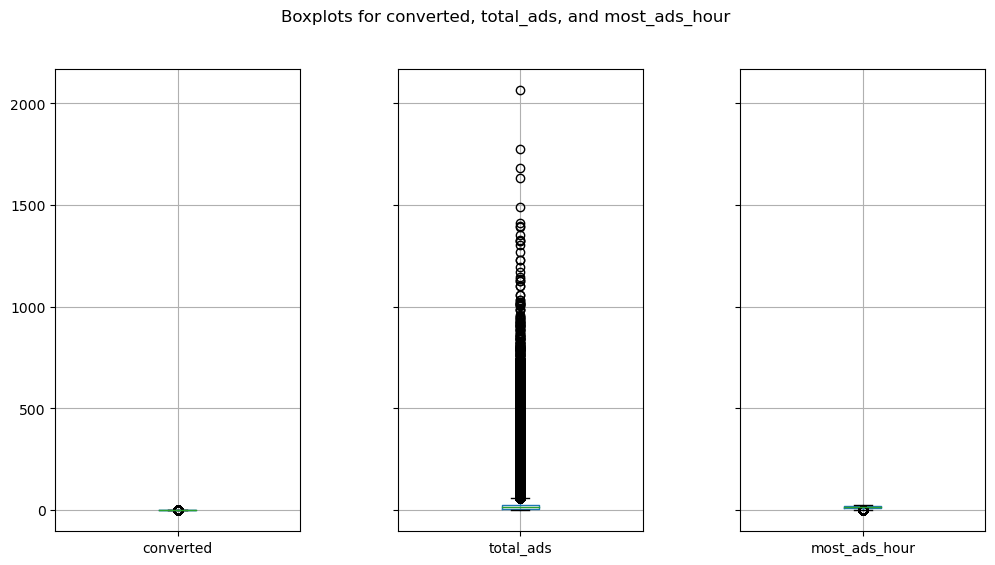

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6), sharey=True)
fig.subplots_adjust(wspace=0.4)

columns = ['converted', 'total_ads', 'most_ads_hour']
for i, column in enumerate(columns):
    df.boxplot(column=column, ax=axs[i])

fig.suptitle('Boxplots for converted, total_ads, and most_ads_hour')

# Показать график
plt.show()

## Анализ данных
Посмотрим на примитивные статистики

In [16]:
df.describe(include="all")

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
count,5.881010e+05,588101,588101.000000,588101.000000,588101,588101.000000
unique,NaN,2,NaN,NaN,7,NaN
top,NaN,ad,NaN,NaN,Friday,NaN
freq,NaN,564577,NaN,NaN,92608,NaN
mean,1.310692e+06,NaN,0.025239,24.820876,NaN,14.469061
std,2.022260e+05,NaN,0.156850,43.715181,NaN,4.834634
min,9.000000e+05,NaN,0.000000,1.000000,NaN,0.000000
25%,1.143190e+06,NaN,0.000000,4.000000,NaN,11.000000
50%,1.313725e+06,NaN,0.000000,13.000000,NaN,14.000000
75%,1.484088e+06,NaN,0.000000,27.000000,NaN,18.000000


### Соотношение тестовой группы

In [17]:
test_group_counts = df["test_group"].value_counts()
test_group_counts

ad     564577
psa     23524
Name: test_group, dtype: int64

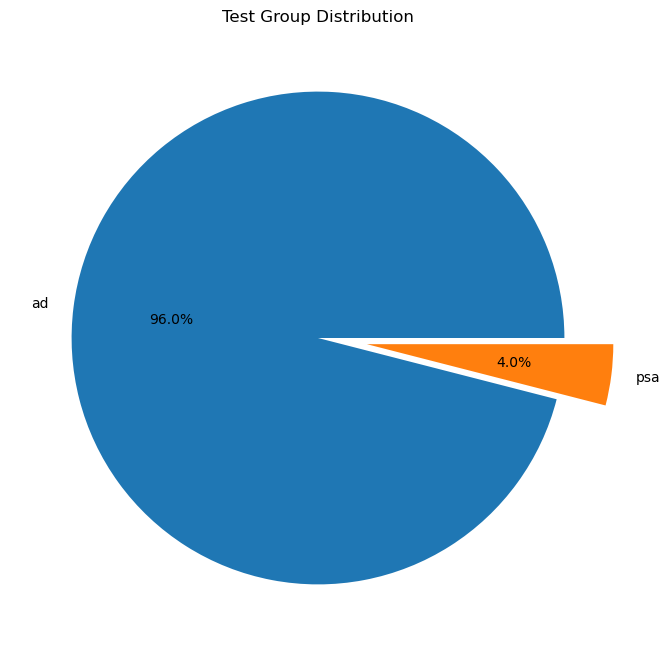

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.pie(test_group_counts.values, 
       labels=test_group_counts.index,
       autopct='%1.1f%%',
       colors=color,
       explode=(0, 0.2))
ax.set_title("Test Group Distribution")

plt.show()

Как можно заметить рекламное объявление было чаще просмотрено, чем объявление службы общественной информации

### Количество купивших

In [19]:
converted_counts = df["converted"].value_counts()

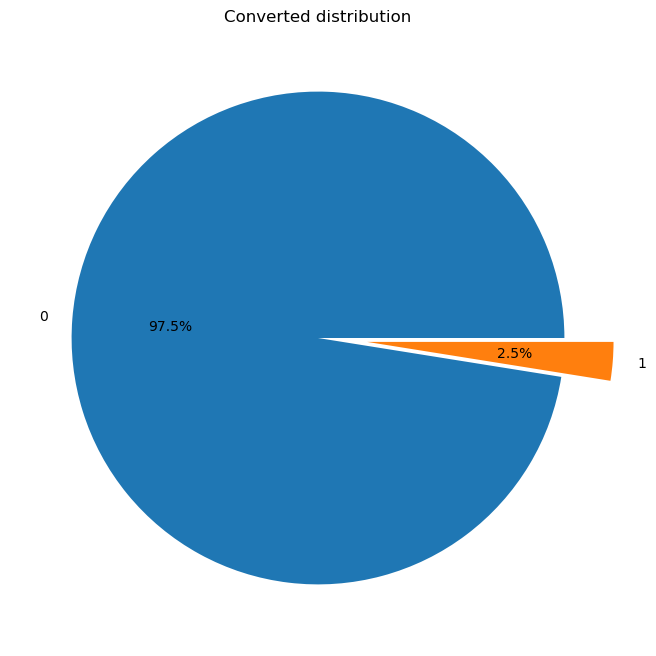

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.pie(converted_counts.values, 
       labels=converted_counts.index,
       autopct='%1.1f%%',
       colors=color,
       explode=(0, 0.2))
ax.set_title("Converted distribution")

plt.show()

Как можно заметить лишь 2.5% людей после просмотры рекламы перешли по ссылке и купили продукт.

###  Распределение конверсии в каждой группе

In [21]:
df_conversion = df.groupby("test_group")["converted"].mean() * 100
df_conversion

test_group
ad     2.554656
psa    1.785411
Name: converted, dtype: float64

Исходя из этих показателей конверсии, можно сделать вывод, что группа ad достигла более высокого показателя конверсии (2,5547%) по сравнению с группой PSA (1,7854%). Это указывает на то, что рекламные объявления успешно генерировали конверсии и рекламная кампания в целом была эффективной.

### Расчет статистик
Рассмотрим, сколько клиентов, принявших участие в различных маркетинговых кампаниях, были затронуты ими и перешли на новые продукты

In [22]:
test_counts = df.pivot_table(values='user_id', index='test_group', columns='converted', aggfunc='count')
test_counts

converted,0,1
test_group,,
ad,550154,14423
psa,23104,420


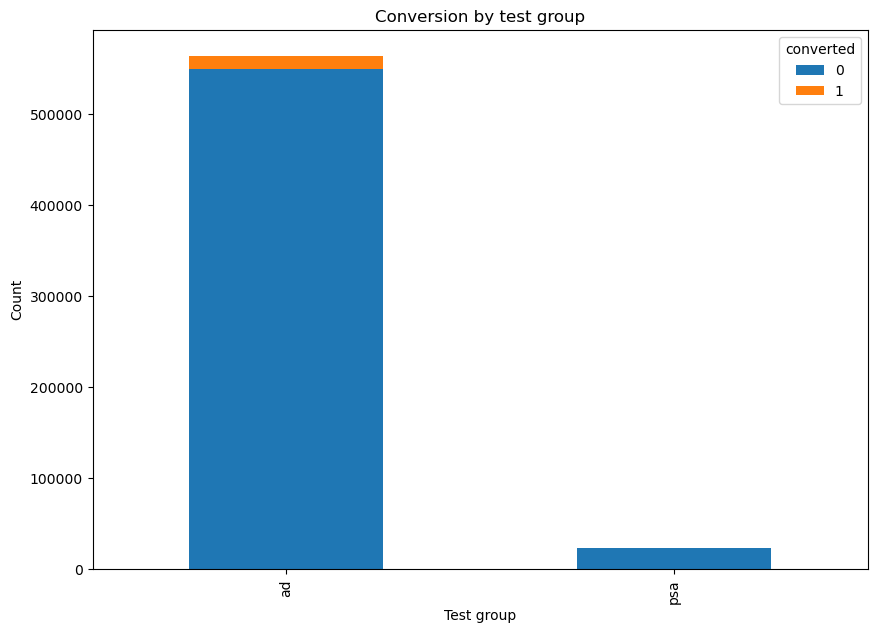

In [23]:
fig, ax = plt.subplots(figsize=(10, 7))

test_counts.plot(kind='bar', stacked=True, ax=ax)

ax.set_xlabel('Test group')
ax.set_ylabel('Count')
plt.title('Conversion by test group')

plt.show()

Как можно визуально оценить, что значительно большее количество людей производило покупки, после просмотра маркетинговой рекламы.

### Распределение конверсии по дням недели
Расмотрим имеется ли зависимость эффективность рекламной кампании от дня недели

In [24]:
conv_per_day = df.groupby("most_ads_day")["converted"].sum()
conv_per_day

most_ads_day
Friday       2057
Monday       2857
Saturday     1719
Sunday       2090
Thursday     1790
Tuesday      2312
Wednesday    2018
Name: converted, dtype: int64

In [25]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

test_group_per_day = df.pivot_table(values='converted', index='most_ads_day', columns='test_group', aggfunc='sum')

test_group_per_day.index = pd.CategoricalIndex(test_group_per_day.index, categories=days_order, ordered=True)

test_group_per_day = test_group_per_day.sort_index()
test_group_per_day

test_group,ad,psa
most_ads_day,,
Monday,2778,79
Tuesday,2270,42
Wednesday,1963,55
Thursday,1711,79
Friday,1995,62
Saturday,1679,40
Sunday,2027,63


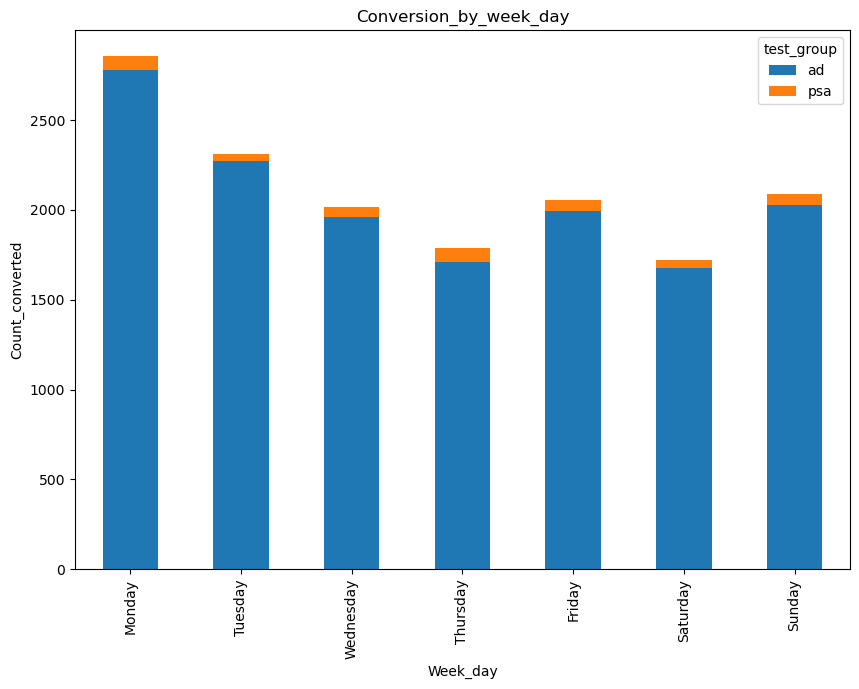

In [26]:
fig, ax = plt.subplots(figsize=(10, 7))

test_group_per_day.plot(kind='bar', stacked=True, ax=ax)

ax.set_xlabel('Week_day')
ax.set_ylabel('Count_converted')
plt.title('Conversion_by_week_day')

plt.show()

Как можно заметить, то наилучший день для показа комерческой рекламы это понедельник, а также понедельник и четверг для общественной рекламы.

### Распределение количества продаж по времени суток

Рассмотрим наиболее успешные часы для каждой из категорий рекламы

In [27]:
most_ads_hour = df.groupby("most_ads_hour")["converted"].sum()
most_ads_hour

most_ads_hour
0      102
1       62
2       39
3       28
4       11
5       16
6       46
7      116
8      344
9      595
10     838
11    1022
12    1127
13    1176
14    1281
15    1325
16    1156
17     987
18     885
19     811
20     862
21     867
22     690
23     457
Name: converted, dtype: int64

In [28]:
test_group_per_hour = df.pivot_table(values='converted', index='most_ads_hour', columns='test_group', aggfunc='sum')
test_group_per_hour

test_group,ad,psa
most_ads_hour,,
0,102,0
1,62,0
2,39,0
3,27,1
4,11,0
5,16,0
6,46,0
7,114,2
8,337,7


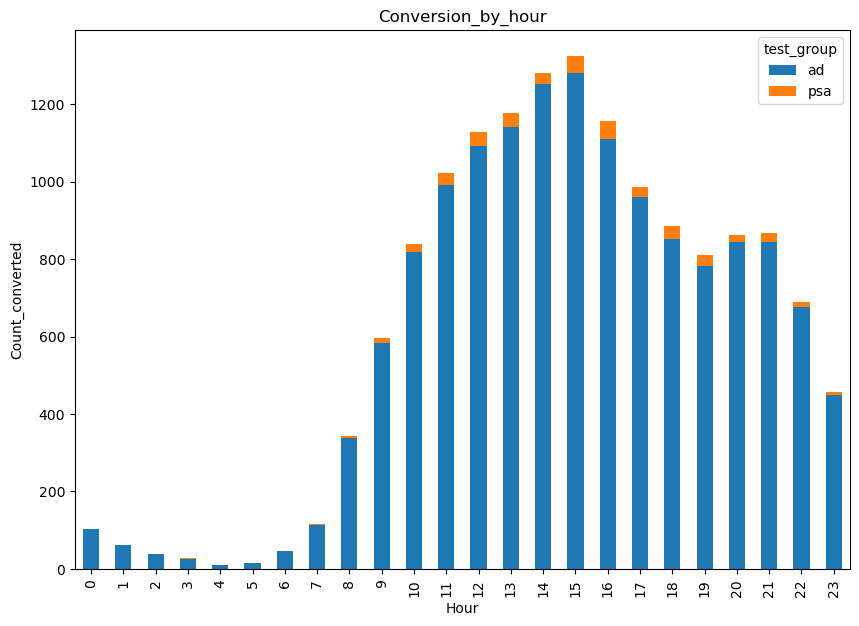

In [29]:
fig, ax = plt.subplots(figsize=(10, 7))

test_group_per_hour.plot(kind='bar', stacked=True, ax=ax)

ax.set_xlabel('Hour')
ax.set_ylabel('Count_converted')
plt.title('Conversion_by_hour')

plt.show()

Как можно заметить, то для 2х видов рекламы в районе 15:00 является наиболее прибыльным. Сам вид распределения имеет мещенный центр, что не удивительно, ведь в период с 0:00 до 6:00 люди в основном спят.

## A/B тестирование
### Проверка нормальности данных

Как можно было заметить, то данные смещены в сторону рекламы, но коверсия была 2,5% и 1.78% проверим на сколько это статистически значимо.

* H0: нет значимой разницы
* H1: значимая разница имеется

In [30]:
ad = df[df["test_group"]=='ad'].reset_index()
psa = df[df["test_group"]=='psa'].reset_index()
ad.shape, psa.shape

((564577, 7), (23524, 7))

In [31]:
converts_ad = ad.groupby("converted")["user_id"].count()
converts_ad

converted
0    550154
1     14423
Name: user_id, dtype: int64

In [32]:
converts_psa = psa.groupby("converted")["user_id"].count()
converts_psa

converted
0    23104
1      420
Name: user_id, dtype: int64

Проверим на нормальность и однородность дисперсии

In [33]:
_, pvalue_ad = st.shapiro(ad.converted)
_, pvalue_psa = st.shapiro(psa.converted)
pvalue_ad, pvalue_psa

/opt/conda/lib/python3.10/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.0, 0.0)

In [34]:
st.levene(psa.converted, ad.converted)

LeveneResult(statistic=54.322884225785735, pvalue=1.703305262368155e-13)

Рассмотрим распределения KDE в двух группах

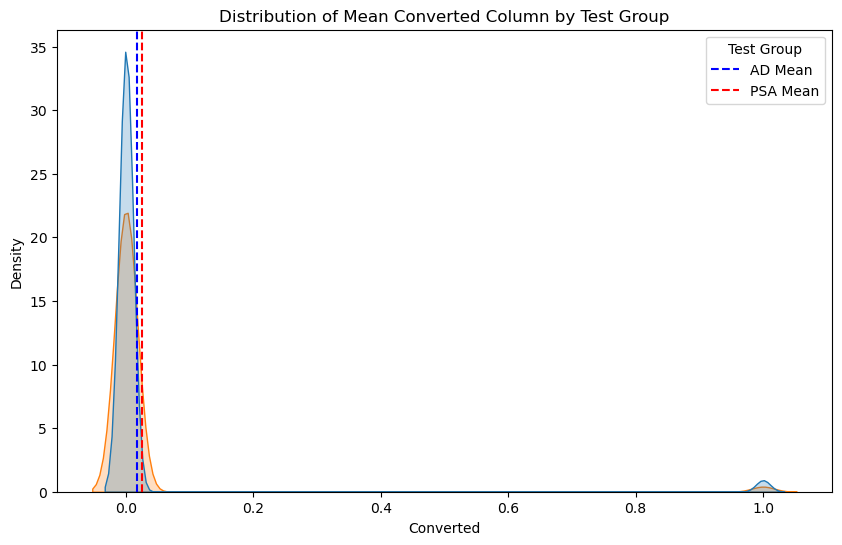

In [38]:
ad_mean = df.loc[df['test_group'] == 'psa', 'converted'].mean()
psa_mean = df.loc[df['test_group'] == 'ad', 'converted'].mean()

fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(data=df, x='converted', hue='test_group', fill=True, common_norm=False)
ax.axvline(ad_mean, color='b', linestyle='--', label='AD Mean')
ax.axvline(psa_mean, color='r', linestyle='--', label='PSA Mean')
plt.title('Distribution of Mean Converted Column by Test Group')
ax.set_xlabel('Converted')
ax.set_ylabel('Density')
ax.legend(title='Test Group')
plt.show()

Также рассмотрим распределения по группам использую bootstrap

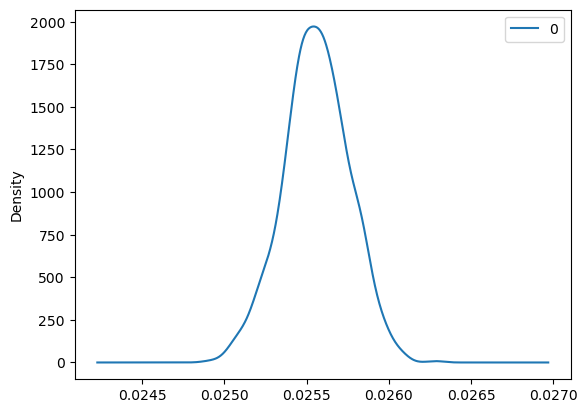

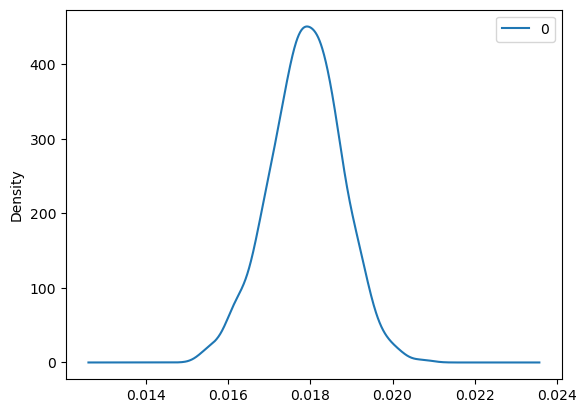

In [40]:
boot_ad=[]
for i in range(1000):
    boot_mean = ad.sample(frac=1, replace=True)['converted'].mean()
    boot_ad.append(boot_mean)
boot_ad=pd.DataFrame(boot_ad)
boot_ad.plot(kind='density');

boot_psa=[]

for i in range(1000):
    boot_mean=psa.sample(frac=1,replace=True)['converted'].mean()
    boot_psa.append(boot_mean)
    
boot_psa=pd.DataFrame(boot_psa)
boot_psa.plot(kind='density');
    

In [ ]:
st.ttest_ind(psa.converted, ad.converted)

Поскольку тест Шапиро-Уилса и критерий однородности соблюдены, так как pvalue < 0.05 и t_test показал pvalue < 0.05, то:

* При таком pvalue отвергается H0, а значит имеется статистически значимое отличия в источниках рекламы
* Разница в конверсиях обусловлена рекламой

## Выводы

В результате исследования были рассмотрены зависимости конверсии от дня недели и от времени суток. Также были рассмотрены сами распределения конверсии и ее эффективность. Проведя shapiro, levene, t_test было подтверждено, что рекламная компания имела статистически значимую разницу с общественной рекламой. Также что 2,5% конверсии рекламы была более эффективна и оправдана.